In [30]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from generator import RoadNetwork, Trajectory
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import GTNModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
network = RoadNetwork()
network.load("../../osm_data/porto")
trajectory = Trajectory("../../datasets/trajectories/Porto/road_segment_map_final.csv", nrows=100000).generate_TTE_datatset()
data = network.generate_road_segment_pyg_dataset()

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GTNModel(data, device, network, trajectory)

100%|██████████| 100000/100000 [00:41<00:00, 2429.46it/s]


In [46]:
model.train_data.edge_index.shape

torch.Size([2, 42903])

In [49]:
model.train(epochs=5000)

In [22]:
adj = conv.generate_node_traj_adj(k=4)

  5%|▍         | 4680/100000 [00:02<01:00, 1575.20it/s]


KeyboardInterrupt: 

In [24]:
rowsum = adj.sum(axis=1, keepdims=True)
adj = adj / rowsum

/tmp/ipykernel_30507/2421131799.py:2: RuntimeWarning: invalid value encountered in true_divide
  adj = adj / rowsum


In [25]:
G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)

In [41]:
weights = torch.Tensor(list(nx.get_edge_attributes(G, "weight").values()))

tensor([0.1147, 0.0103, 0.1043,  ...,    nan,    nan,    nan])

Ellipsis

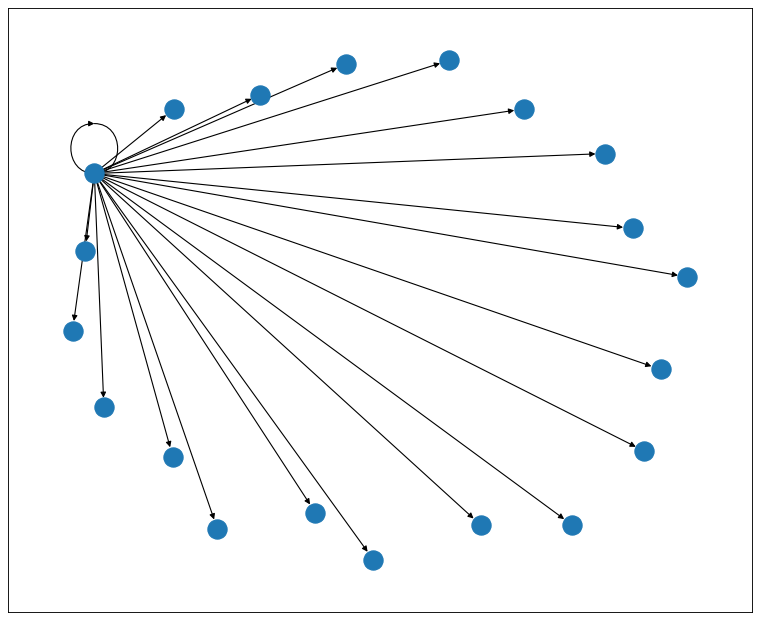

In [29]:
nodes = list(G.neighbors(0)) + [0]
sg = G.subgraph(nodes)
pos = nx.spring_layout(sg, seed=7, k=10) 

plt.figure(figsize=(12, 10), dpi=80)

nx.draw_networkx_nodes(sg, pos=pos)
nx.draw_networkx_edges(sg, pos=pos, edgelist=list(sg.out_edges(0)))
#edge_labels = nx.get_edge_attributes(sg, "weight")
#nx.draw_networkx_edge_labels(sg, pos, edge_labels)

...
